In [1]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_absolute_error

In [2]:
#define wrangle function
def wrangle(dataset):
    #read csv
    df = pd.read_csv(dataset)
    #cols to drop
    cols_to_drop = ['PoolQC','Alley','MiscFeature','Fence', 'FireplaceQu','MasVnrType', 'Id']

    #handle categorical missingness
    categ_vars = df.select_dtypes('object').columns
    for cat_col in categ_vars:
        df[cat_col] = df[cat_col].fillna(df[cat_col].mode()[0])
    
    #handle numerical missingness
    num_cols = df.select_dtypes(['int','float']).columns
    for num in num_cols:
        df[num] = df[num].fillna(df[num].mean())
    #drop multicollinearity
    collinear = ['BedroomAbvGr', 'GarageYrBlt', '2ndFlrSF', '1stFlrSF']

    #drop cols
    df.drop(columns = cols_to_drop, inplace=True)

    return df

In [3]:
df = wrangle('train.csv')
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 74 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

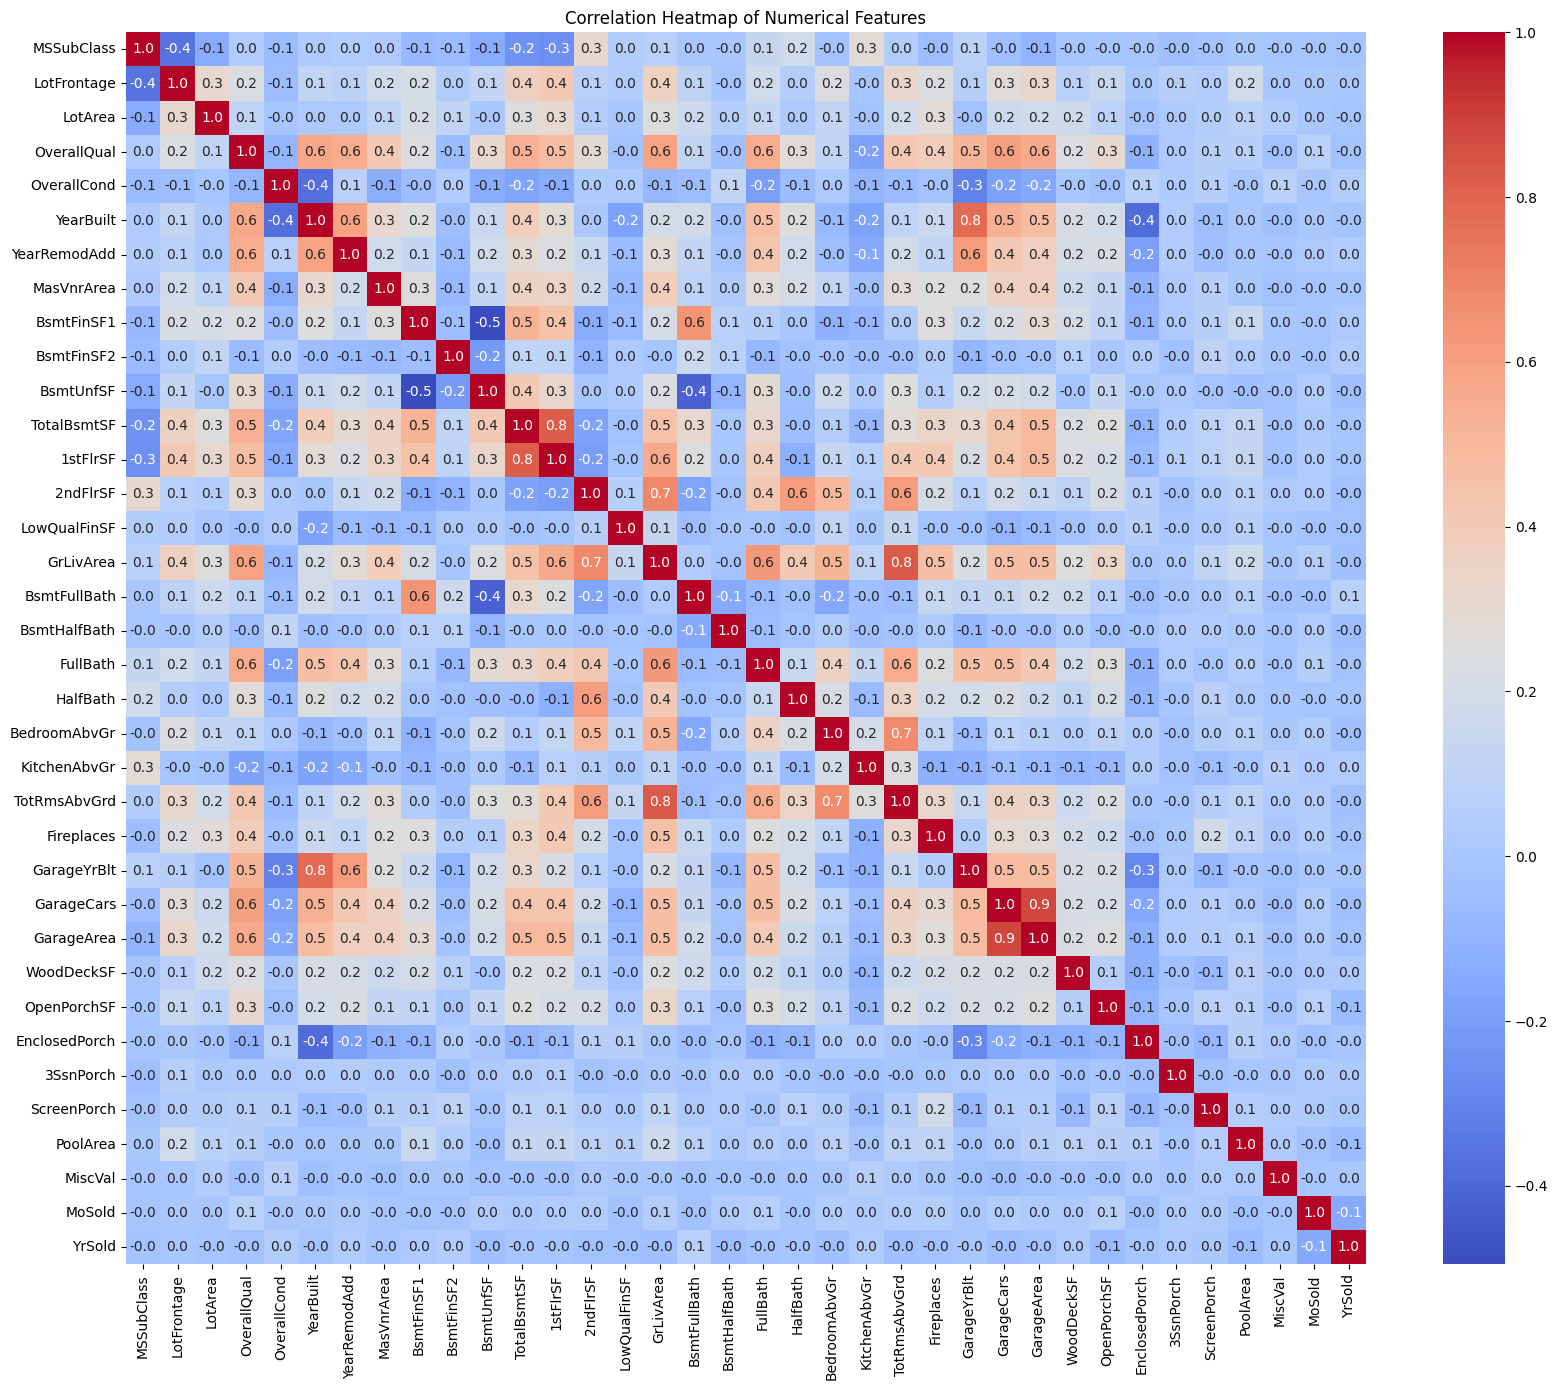

In [5]:
#check correlation for numerical features
num_feat = df.select_dtypes(['int', 'float']).drop('SalePrice', axis=1).corr()
plt.figure(figsize=(20, 16))
sns.heatmap(num_feat, cmap='coolwarm', annot=True, fmt='.1f')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

In [6]:
#num cols
num_feats = df.select_dtypes(['int', 'float']).drop('SalePrice', axis=1).columns
num_feats

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [9]:
df[['GrLivArea', 'BedroomAbvGr', 'TotRmsAbvGrd']].corr()


,GrLivArea,BedroomAbvGr,TotRmsAbvGrd
GrLivArea,1.000000,0.52127,0.825489
BedroomAbvGr,0.521270,1.00000,0.676620
TotRmsAbvGrd,0.825489,0.67662,1.000000


In [11]:
df[['GarageYrBlt', 'YearBuilt']].corr()
#YearBuilt

,GarageYrBlt,YearBuilt
GarageYrBlt,1.000000,0.780555
YearBuilt,0.780555,1.000000


In [12]:
df['GrLivArea'].corr(df['2ndFlrSF'])


0.6875010641666036

In [ ]:
1stFlrSF
TotRmsAbvGrd